In [9]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
#=========== general settings ============================#
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.subplot.wspace"] = 0.4

plt.rcParams['font.family'] ='sans-serif'#使用するフォント
plt.rcParams['font.sans-serif'] ='Arial'#使用するフォント
plt.rcParams["font.size"] = 30
#plt.rcParams['mathtext.rm'] ='sans'#使用するフォント
#plt.rcParams['mathtext.default'] ='rm'#使用するフォント

plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams["xtick.major.pad"] = 19.0
plt.rcParams["ytick.major.pad"] = 16.0
plt.rcParams["xtick.major.size"] = 10
plt.rcParams["ytick.major.size"] = 10

plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ
plt.rcParams["axes.labelpad"] = 10
#==================================================================#

In [11]:
nn = np.matrix([[1],[0],[0]]) 
dirc = str(nn[0,0]) + str(nn[1,0])+str(nn[2,0])

In [12]:
def ASR(t, s11, s22, s33, s12, s23, s13, p0, K, G, ts, tv):
    #n = np.matrix([[n11,n12,n13,n14,n15,n16, n17, n18, n19],[n21,n22,n23,n24,n25,n26, n27, n28, n29],[n31,n32,n33,n34,n35,n36, n37, n38, n39]])
    n = nn / np.linalg.norm(nn)

    Jav = (1-np.exp(-t/tv))/(3*K*10**3)
    Jas = (1-np.exp(-t/ts))/(2*G*10**3)
    
    nTn = (s11*n[0]*n[0] + s22*n[1]*n[1] + s33*n[2]*n[2]
           + 2*s12*n[0]*n[1] + 2*s23*n[1]*n[2] + 2*s13*n[0]*n[2]
          )
    
    sm = (1.0/3.0)*(s11 + s22 + s33)
  
    es = (nTn - sm)*Jas
    ev = (sm - p0)*Jav
    
    e = es + ev
    
    return e*10**6

In [13]:
problem = {
    'num_vars': 11,
    'names': ['s11', 's22', 's33', 's12', 's23', 's13', 'p0', 'K', 'G', 'ts', 'tv'],
    'bounds': [
               [0, 100],
               [0, 100],
               [0, 100],
               [0, 100],
               [0, 100],
               [0, 100],
               [0, 100],
               [0, 100],
               [0, 100],
               [0, 50],
               [0, 50],
               ]
}

In [14]:
param_values = saltelli.sample(problem, 50)

In [15]:
def S(t):
    Y = np.zeros([param_values.shape[0]])
    
    for i, (s11, s22, s33, s12, s23, s13, p0, K, G, ts, tv) in enumerate(param_values):
        Y[i] = ASR(t, s11, s22, s33, s12, s23, s13, p0, K, G, ts, tv)
        
    Si = sobol.analyze(problem, Y, print_to_console=False)
    return np.array([[t, Si["S1"][0], Si["S1_conf"][0], Si["S1"][2], Si["S1_conf"][2]]])

In [17]:
columns = ["time[h]",
           "s11","s11_err",
           "s12","s12_err"
          ]

Sobol = pd.DataFrame(index=[], columns=columns)

In [18]:
for t in range(1, 500, 10):
    Si_p = pd.DataFrame(data = S(t), columns = columns)
    Sobol = Sobol.append(Si_p)
Sobol.to_csv("Sobol"+dirc + ".csv", index=False)

Y = np.zeros([param_values.shape[0]])

for i, (s11, s22, s33, s12, s23, s13, p0, K, G, ts, tv) in enumerate(param_values):
    Y[i] = ASR(t, s11, s22, s33, s12, s23, s13, p0, K, G, ts, tv, dt)

Si = sobol.analyze(problem, Y, print_to_console=False)

<BarContainer object of 11 artists>

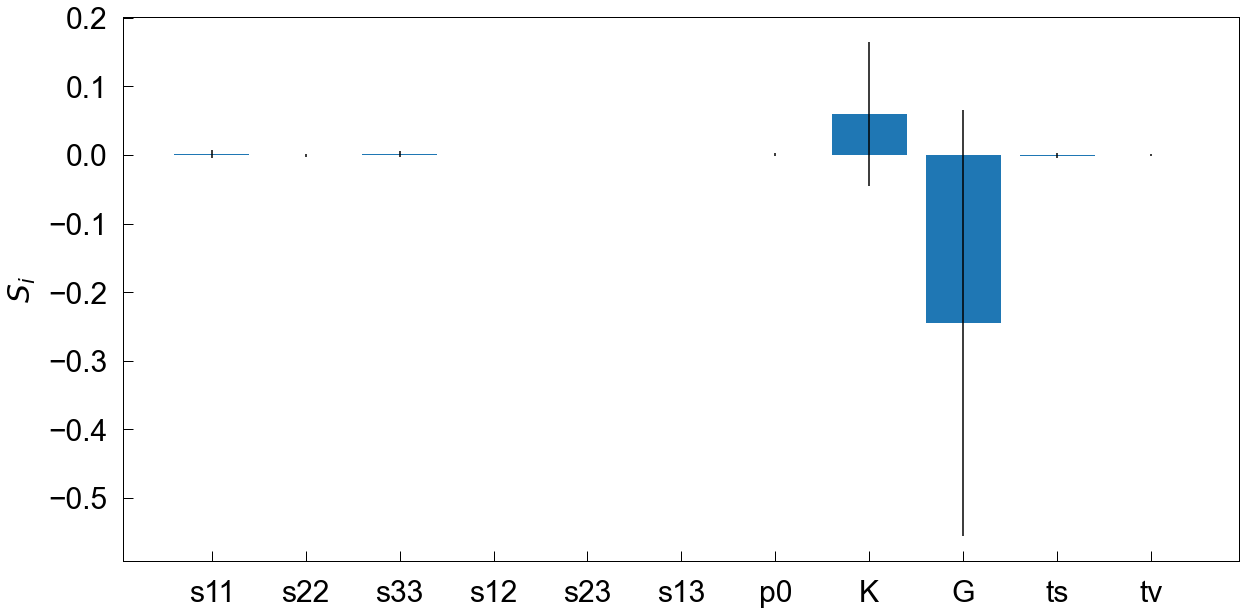

In [8]:
x = np.arange(problem['num_vars'])
plt.xticks(x, problem['names'])
plt.ylabel('$S_{i}$')
plt.bar(x, S(2)['S1'], yerr = S(2)['S1_conf'])

<BarContainer object of 12 artists>

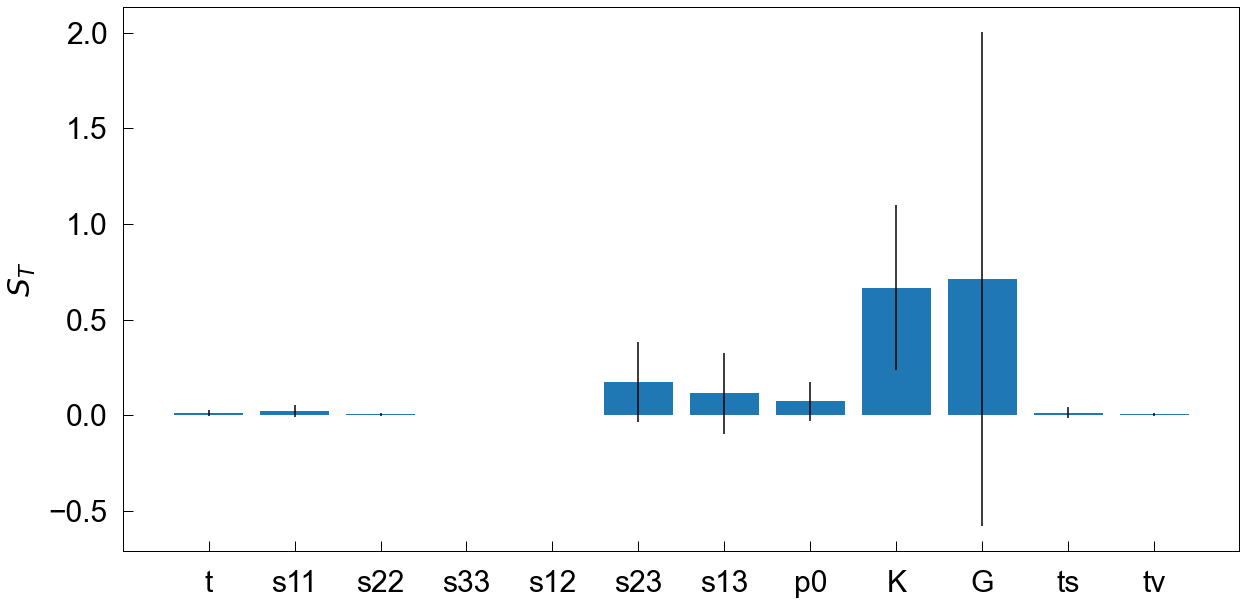

In [19]:
x = np.arange(problem['num_vars'])
plt.xticks(x, problem['names'])
plt.ylabel('$S_{T}$')
plt.bar(x, Si['ST'], yerr = Si['ST_conf'])